In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow.keras.layers as layers
import tensorflow.keras.models as models
from keras import optimizers
from keras.utils import load_img, img_to_array
from sklearn.model_selection import train_test_split
from keras.utils import load_img, img_to_array

2025-07-08 18:41:50.554764: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752000110.778119      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752000110.843185      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [29]:
# Vérifier le GPU
print("GPU disponible:", tf.config.list_physical_devices('GPU'))

# Exploitation des données
data_dir = '/kaggle/input/'
print("Contenu du dossier:", os.listdir(data_dir))

GPU disponible: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
Contenu du dossier: ['microsoft-catsvsdogs-dataset']


In [25]:
# Explorer la structure
for root, dirs, files in os.walk(data_dir):
    level = root.replace(data_dir, '').count(os.sep)
    indent = ' ' * 2 * level
    print(f"{indent}{os.path.basename(root)}/")
    subindent = ' ' * 2 * (level + 1)
    if len(files) > 0:
        print(f"{subindent}{len(files)} fichiers")


# Chemins des données
data_dir = '/kaggle/input/microsoft-catsvsdogs-dataset'
pet_images_dir = os.path.join(data_dir, 'PetImages')
print("Contenu du dossier:", os.listdir(data_dir))

# Dossier des chats
cats_dir = os.path.join(pet_images_dir, 'Cat')  
# Dossier des chiens  
dogs_dir = os.path.join(pet_images_dir, 'Dog') 

print("Chemin d'accès des chats :", cats_dir)
print("Chemin d'accès des chiens :", dogs_dir)

/
  2 fichiers
PetImages/
  Dog/
    12501 fichiers
  Cat/
    12501 fichiers
Contenu du dossier: ['PetImages', 'readme[1].txt', 'MSR-LA - 3467.docx']
Chemin d'accès des chats : /kaggle/input/microsoft-catsvsdogs-dataset/PetImages/Cat
Chemin d'accès des chiens : /kaggle/input/microsoft-catsvsdogs-dataset/PetImages/Dog


# FONCTIONS

In [47]:
# Fonction pour charger les données
def charger_donnees(pet_images_dir):
    tous_fichiers = []
    categories = []
    
    # Dossier des chats
    cats_dir = os.path.join(pet_images_dir, 'Cat')
    print(f"Chargement des chats depuis: {cats_dir}")
    cat_files = os.listdir(cats_dir)
    for filename in cat_files:
        if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
            tous_fichiers.append(os.path.join(cats_dir, filename))
            categories.append(0)  # 0 pour chat
    
    # Dossier des chiens
    dogs_dir = os.path.join(pet_images_dir, 'Dog')
    print(f"Chargement des chiens depuis: {dogs_dir}")
    dog_files = os.listdir(dogs_dir)
    for filename in dog_files:
        if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
            tous_fichiers.append(os.path.join(dogs_dir, filename))
            categories.append(1)  # 1 pour chien
    
    return tous_fichiers, categories


# Sélectionner aléatoirement 10 images de chats et de chiens
def selectionner_images_aleatoire(df, n): 
    chats_df = df[df['category'] == 0].sample(n=n, random_state=42)
    chiens_df = df[df['category'] == 1].sample(n=n, random_state=42)
    
    # Combiner les deux DataFrames
    df_final = pd.concat([chats_df, chiens_df]).reset_index(drop=True)
    
    # S'assurer que la colonne 'category' contient des chaînes de caractères
    df_final['category'] = df_final['category'].astype(str)

    return df_final


# Fonction pour afficher l'image originale et transformée
def plot_before_and_after(original, transformed, title):
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.title("Original")
    plt.imshow(original)
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title(title)
    plt.imshow(transformed)
    plt.axis('off')

    plt.show()


# Fonction pour afficher les courbes d'apprentissage
def plot_curves(model_history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    epochs = range(1, len(acc) + 1)
      
    # Tracer la courbe de précision
    plt.figure(figsize=(14, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'bo-', label='Précision entraînement')  # 'bo-' : bleu avec des points et lignes
    plt.plot(epochs, val_acc, 'r^-', label='Précision validation')  # 'r^-' : rouge avec des triangles et lignes
    plt.title('Précision entraînement et validation')
    plt.xlabel('Époques')
    plt.ylabel('Précision')
    plt.legend()

    
    # Tracer la courbe de perte
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'bo-', label='Perte entraînement')  # 'bo-' : bleu avec des points et lignes
    plt.plot(epochs, val_loss, 'r^-', label='Perte validation')  # 'r^-' : rouge avec des triangles et lignes
    plt.title('Perte entraînement et validation')
    plt.xlabel('Époques')
    plt.ylabel('Perte')
    plt.legend()
    
    plt.tight_layout()
    plt.show()



# Fonction de Data génération
def train_val_generator(df_train, df_test):
    # 1. Préparation des générateurs de données
    
    # Appliquer des transformations et normaliser les images pour l'ensemble d'entraînement
    train_datagen = ImageDataGenerator(
        rescale=1./255,          # Normaliser les valeurs des pixels
        rotation_range=40,       # Rotation aléatoire des images jusqu'à 40 degrés
        width_shift_range=0.2,   # Décalage horizontal aléatoire jusqu'à 20%
        height_shift_range=0.2,  # Décalage vertical aléatoire jusqu'à 20%
        shear_range=0.2,         # Cisaillement aléatoire
        zoom_range=0.2,          # Zoom aléatoire jusqu'à 20%
        horizontal_flip=True,    # Retourner les images horizontalement
        fill_mode='nearest'      # Mode de remplissage pour les nouveaux pixels
    )
    
    # Normaliser les images pour l'ensemble de validation
    val_datagen = ImageDataGenerator(rescale=1./255)  # Normaliser les valeurs des pixels


    # 2. Génration des données

    # Générateur de données pour l'entraînement
    train_generator = train_datagen.flow_from_dataframe(
        df_train,
        pet_images_dir,
        directory=
        x_col='filename',                  # Nom de colonne pour les noms de fichiers
        y_col='category',                  # Nom de colonne pour les catégories
        target_size=(150, 150),            # Redimensionner les images à 150x150 pixels
        batch_size=32,                     # Nombre d'images par lot
        class_mode='binary'                # Mode de classification binaire (chat ou chien)
    )
    
    # Générateur de données pour la validation
    validation_generator = val_datagen.flow_from_dataframe(
        df_test,
        pet_images_dir,
        x_col='filename',                  # Nom de colonne pour les noms de fichiers
        y_col='category',                  # Nom de colonne pour les catégories
        target_size=(150, 150),            # Redimensionner les images à 150x150 pixels
        batch_size=32,                     # Nombre d'images par lot
        class_mode='binary'                # Mode de classification binaire (chat ou chien)
    )


    return train_generator, validation_generator



# Extraire les feactures des données via un pre-trained model
def extract_features(df, sample_count):
  features = np.zeros(shape=(sample_count, 4, 4, 512))
  labels = np.zeros(shape=(sample_count))
  generator = data_gen.flow_from_dataframe(df,
                                          filepath,
                                          x_col='filename',
                                          y_col='category',
                                           target_size=(150, 150),
                                           batch_size=batch_size,
                                           class_mode='binary')
  for idx, (inputs_batch, labels_batch) in enumerate(generator):
    features_batch = conv_base.predict(inputs_batch)
    features[idx * batch_size: (idx + 1) * batch_size] = features_batch
    labels[idx * batch_size: (idx + 1) * batch_size] = labels_batch
    if (idx + 1) * batch_size >= sample_count:
      break

  return features, labels

SyntaxError: invalid syntax (2453992807.py, line 119)

In [6]:
# Charger les données
noms_fichiers, categories = charger_donnees(pet_images_dir)

print(f"\nTotal d'images : {len(noms_fichiers)}")
print(f"Chats : {categories.count(0)}")
print(f"Chiens : {categories.count(1)}")

Chargement des chats depuis: /kaggle/input/microsoft-catsvsdogs-dataset/PetImages/Cat
Chargement des chiens depuis: /kaggle/input/microsoft-catsvsdogs-dataset/PetImages/Dog

Total d'images : 25000
Chats : 12500
Chiens : 12500


In [36]:
# Créer un DataFrame avec pandas pour y mettre les données
df = pd.DataFrame({
    'filename': noms_fichiers,
    'category': categories
})

# Afficher du DataFrame
df

,filename,category
0,/kaggle/input/microsoft-catsvsdogs-dataset/Pet...,0
1,/kaggle/input/microsoft-catsvsdogs-dataset/Pet...,0
2,/kaggle/input/microsoft-catsvsdogs-dataset/Pet...,0
3,/kaggle/input/microsoft-catsvsdogs-dataset/Pet...,0
4,/kaggle/input/microsoft-catsvsdogs-dataset/Pet...,0
...,...,...
24995,/kaggle/input/microsoft-catsvsdogs-dataset/Pet...,1
24996,/kaggle/input/microsoft-catsvsdogs-dataset/Pet...,1
24997,/kaggle/input/microsoft-catsvsdogs-dataset/Pet...,1
24998,/kaggle/input/microsoft-catsvsdogs-dataset/Pet...,1


In [39]:
# Créer une nouvelle colonne avec les chemins relatifs à base_dir
df['filename'] = df['filename'].apply(lambda x: os.path.join(*x.split('/')[-2:]))

print(df.head())
df.tail()

       filename  category
0  Cat/7981.jpg         0
1  Cat/6234.jpg         0
2  Cat/1269.jpg         0
3  Cat/3863.jpg         0
4  Cat/6241.jpg         0


,filename,category
24995,Dog/8152.jpg,1
24996,Dog/3361.jpg,1
24997,Dog/2599.jpg,1
24998,Dog/10035.jpg,1
24999,Dog/11590.jpg,1


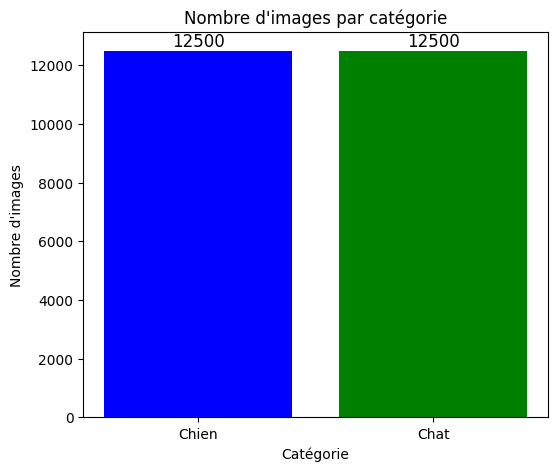

In [40]:
# Créer un graphique en nombre des catégories
compte_categories = df['category'].value_counts()
noms_categories = ['Chien', 'Chat']


plt.figure(figsize=(6, 5))
couleurs = ['blue', 'green']  # Couleurs compréhensibles
plt.bar(noms_categories, compte_categories, color=couleurs)
plt.xlabel('Catégorie')
plt.ylabel('Nombre d\'images')
plt.title('Nombre d\'images par catégorie')

for i, v in enumerate(compte_categories):
    plt.text(i, v, str(v), ha='center', va='bottom', fontsize=12, color='black')

/kaggle/input/microsoft-catsvsdogs-dataset/PetImages/Cat/7793.jpg


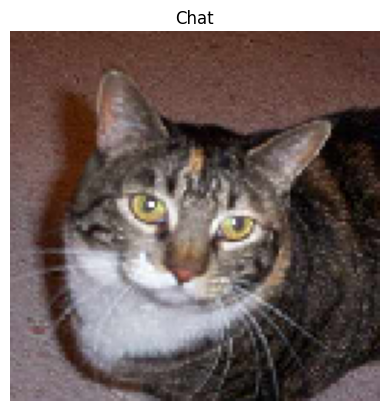

In [19]:
# Sélectionner une image aléatoire
image_aleatoire = random.choice(noms_fichiers)
print(image_aleatoire)

# Charger et afficher l'image
img = image.load_img(image_aleatoire, target_size=(128, 128))
plt.imshow(img)
categorie = 'Chien' if image_aleatoire.split('/')[-2] == 'Dog' else 'Chat'
plt.title(categorie)
plt.axis('off')
plt.show()

## Prétraitement des données pour la génération d'images

1. Lire les fichiers d'image

La première étape consiste à lire les fichiers d'image à partir de votre stockage. Cela permet de charger les images brutes dans votre programme pour les étapes suivantes de prétraitement.

2. Décoder le contenu JPEG en grilles de pixels RGB

Une fois que les images sont lues, nous devons les décoder à partir de leur format JPEG compressé en grilles de pixels RGB (Rouge, Vert, Bleu). Cela transforme l'image en une matrice de valeurs numériques représentant les couleurs.

3. Convertir ces grilles en tableaux de nombres à virgule flottante

Les réseaux de neurones travaillent mieux avec des nombres. Nous devons donc convertir les grilles de pixels en tableaux de nombres à virgule flottante pour pouvoir les utiliser dans nos modèles de deep learning.

4. Rescaler les valeurs des pixels entre 0 et 255 à l'intervalle 0,1

Les réseaux de neurones préfèrent traiter des valeurs d'entrée petites et normalisées. Nous devons donc rescaler les valeurs des pixels de leur intervalle original [0, 255] à l'intervalle [0, 1].

Cette étape de normalisation permet d'améliorer la performance et la stabilité du modèle d'apprentissage, en garantissant que les valeurs d'entrée sont petites et homogènes.

In [41]:
# Sélectionner aléatoirement 1500 images de chats (catégorie 0)
df_final = selectionner_images_aleatoire(df, n=1500)
df_final

,filename,category
0,Cat/12484.jpg,0
1,Cat/2572.jpg,0
2,Cat/3839.jpg,0
3,Cat/5257.jpg,0
4,Cat/5865.jpg,0
...,...,...
2995,Dog/420.jpg,1
2996,Dog/12258.jpg,1
2997,Dog/9899.jpg,1
2998,Dog/10112.jpg,1


In [42]:
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Ré-échelle les valeurs des pixels entre 0 et 255 à l'intervalle 0,1
    validation_split=0.2  # 20% des données pour la validation
)

In [45]:
# S'assurer que la colonne 'category' contient des chaînes de caractères
df_final['category'] = df_final['category'].astype(str)

# Générateur pour les données d'entraînement
train_generator = train_datagen.flow_from_dataframe(
    df_final,
    pet_images_dir,
    x_col='filename',
    y_col='category',
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    subset='training'  # Utiliser les données d'entrainnement
)


# Générateur pour les données de validation
validation_generator = train_datagen.flow_from_dataframe(
    df_final,
    pet_images_dir,
    x_col='filename',
    y_col='category',
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    subset='validation'  # Utiliser les données de validation
)

Found 2400 validated image filenames belonging to 2 classes.
Found 600 validated image filenames belonging to 2 classes.


Taille du lot de données : (32, 150, 150, 3)
Taille du lot d'étiquettes : (32,)


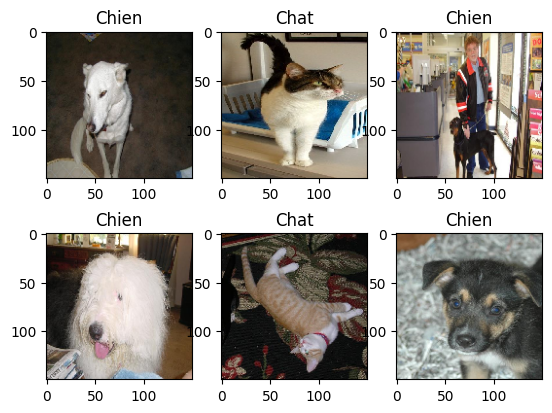

In [46]:
# Affichage de quelques images pour vérifier le prétraitement
for data_batch, labels_batch in train_generator:
    print("Taille du lot de données :", data_batch.shape)  # Affiche la forme du lot de données
    print("Taille du lot d'étiquettes :", labels_batch.shape)  # Affiche la forme du lot d'étiquettes
    for i in range(6):
        plt.subplot(2, 3, i + 1)
        plt.imshow(data_batch[i])  # Affiche l'image prétraitée
        plt.title("Chat" if labels_batch[i] == 0 else "Chien")  # Titre en fonction de l'étiquette
    plt.show()
    break  # Affiche un seul lot d'images

## Convolutional Neural Network (CNN)

Création du réseau de neuronnes

In [48]:
model = models.Sequential()

# Ajouter les couches une par une

model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))  # Couche de convolution : 32 filtres de 3x3, détecte des motifs simples dans l'image, ReLU pour rendre le modèle non-linéaire, forme d'entrée (150x150x3).

model.add(layers.MaxPooling2D((2, 2)))  # Couche de max pooling : réduit les dimensions de l'image en prenant le maximum de chaque carré de 2x2 pixels.

model.add(layers.Conv2D(64, (3, 3), activation='relu'))  # Deuxième couche de convolution : 64 filtres de 3x3, détecte des motifs plus complexes, ReLU pour l'activation.

model.add(layers.MaxPooling2D((2, 2)))  # Deuxième couche de max pooling : réduit encore les dimensions de l'image.

model.add(layers.Conv2D(128, (3, 3), activation='relu'))  # Troisième couche de convolution : 128 filtres de 3x3, détecte des motifs encore plus complexes, ReLU pour l'activation.

model.add(layers.MaxPooling2D((2, 2)))  # Troisième couche de max pooling : réduit encore les dimensions de l'image.

model.add(layers.Flatten())  # Couche Flatten : transforme les données 2D en un vecteur 1D pour la couche dense suivante.

model.add(layers.Dense(512, activation='relu'))  # Couche dense (fully connected) : 512 neurones, chaque neurone est connecté à tous les neurones de la couche précédente, ReLU pour l'activation.

model.add(layers.Dense(1, activation='sigmoid'))  # Couche de sortie : 1 neurone, activation sigmoïde pour produire une probabilité entre 0 et 1, utilisée pour la classification binaire (chat ou chien).


# Summary
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1752002893.951090      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1752002893.951764      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    18,940,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,034,177 (72.61 MB)

 Trainable params: 19,034,177 (72.61 MB)

 Non-trainable params: 0 (0.00 B)

In [49]:
# Complier le model
optimi = optimizers.RMSprop(learning_rate=1e-4)
model.compile(optimizer=optimi,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [50]:
# Entraînement du modèle et sauvegarde de l'historique d'entraînement dans 'history'
history = model.fit(
    train_generator,  # Utilise le générateur pour les données d'entraînement

    # Le nombre d'étapes (batches) à exécuter à chaque époque.
    # Calculé comme le nombre total d'échantillons d'entraînement divisé par la taille du lot.
    steps_per_epoch=train_generator.samples // train_generator.batch_size,

    epochs=30,  # Nombre total d'époques pour l'entraînement

    validation_data=validation_generator,  # Utilise le générateur pour les données de validation

    # Le nombre d'étapes (batches) à exécuter pour chaque époque de validation.
    # Calculé comme le nombre total d'échantillons de validation divisé par la taille du lot.
    validation_steps=validation_generator.samples // validation_generator.batch_size
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30


I0000 00:00:1752003097.881457      86 service.cc:148] XLA service 0x7ba92400a070 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1752003097.882588      86 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1752003097.882611      86 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1752003098.216128      86 cuda_dnn.cc:529] Loaded cuDNN version 90300


 1/75 ━━━━━━━━━━━━━━━━━━━━ 7:33 6s/step - accuracy: 0.5312 - loss: 0.6928

I0000 00:00:1752003102.101612      86 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


50/75 ━━━━━━━━━━━━━━━━━━━━ 5s 202ms/step - accuracy: 0.6079 - loss: 0.6603

/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


75/75 ━━━━━━━━━━━━━━━━━━━━ 26s 264ms/step - accuracy: 0.6139 - loss: 0.6558 - val_accuracy: 0.0000e+00 - val_loss: 1.0132
Epoch 2/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 85ms/step - accuracy: 0.6379 - loss: 0.6168 - val_accuracy: 0.0052 - val_loss: 1.1548
Epoch 3/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 87ms/step - accuracy: 0.6557 - loss: 0.6026 - val_accuracy: 0.4462 - val_loss: 0.7646
Epoch 4/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 84ms/step - accuracy: 0.6992 - loss: 0.5627 - val_accuracy: 0.3941 - val_loss: 0.8185
Epoch 5/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 82ms/step - accuracy: 0.7440 - loss: 0.5407 - val_accuracy: 0.3038 - val_loss: 0.9457
Epoch 6/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 82ms/step - accuracy: 0.7528 - loss: 0.5182 - val_accuracy: 0.5226 - val_loss: 0.7468
Epoch 7/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 85ms/step - accuracy: 0.7609 - loss: 0.4925 - val_accuracy: 0.4462 - val_loss: 0.8740
Epoch 8/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 84ms/step - accuracy: 0.7700 - loss: 0.4720 - val_accuracy: 0.4514 - val_lo

In [51]:
# Évaluer les performances du modèle sur la base de validation
validation_steps = validation_generator.samples // validation_generator.batch_size
evaluation = model.evaluate(validation_generator, steps=validation_steps)

# Afficher les résultats de l'évaluation
print(f"Perte sur la validation: {evaluation[0]}")
print(f"Précision sur la validation: {evaluation[1]}")

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 0.5741 - loss: 1.3561
Perte sur la validation: 1.3795390129089355
Précision sur la validation: 0.5902777910232544


In [ ]:
# Afficher les courbes d'apprentissage
plot_curves(history)

RMQ : 
* Précision :
La précision sur les données d'entraînement augmente régulièrement au fil des époques, ce qui indique que le modèle apprend correctement sur l’ensemble d'entraînement.
En revanche, la précision sur les données de validation fluctue fortement et ne s'améliore pas clairement, ce qui suggère que le modèle ne généralise pas bien aux données qu’il n’a jamais vues.
* Fonction de perte (loss) :
La perte sur l'entraînement diminue progressivement, ce qui est cohérent avec une phase d’apprentissage normale.
    Cependant, la perte sur la validation reste élevée ou stagne, voire augmente, ce qui est un signe classique de surapprentissage (overfitting).
* Conclusion :
Il y a un overfitting évident : le modèle apprend trop bien les données d’entraînement mais échoue à généraliser.
* Cela peut être dû à :
    - un jeu de données trop petit ou déséquilibré,
    - un modèle trop complexe par rapport à la quantité de données,
    - un manque de régularisation (ex : pas d'augmentation de données, pas de dropout...).

#### TEST 

In [54]:
# Générateur pour les données de test
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_dataframe(
    df_final,
    pet_images_dir,
    x_col='filename',
    y_col='category',
    target_size=(150, 150),
    batch_size=10,
    class_mode='binary',
    shuffle=False  # Ne pas mélanger les données de test
)

Found 3000 validated image filenames belonging to 2 classes.


In [55]:
# Faire des prédictions
predictions = model.predict(test_generator)

# Convertir les prédictions en classes (0 ou 1)
predicted_classes = (predictions > 0.5).astype(int).flatten()

# Ajouter les prédictions au DataFrame
df_final['predictions'] = predicted_classes
df_final

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


176/300 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step

/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


300/300 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step


,filename,category,predictions
0,Cat/12484.jpg,0,0
1,Cat/2572.jpg,0,1
2,Cat/3839.jpg,0,0
3,Cat/5257.jpg,0,0
4,Cat/5865.jpg,0,0
...,...,...,...
2995,Dog/420.jpg,1,1
2996,Dog/12258.jpg,1,1
2997,Dog/9899.jpg,1,1
2998,Dog/10112.jpg,1,1


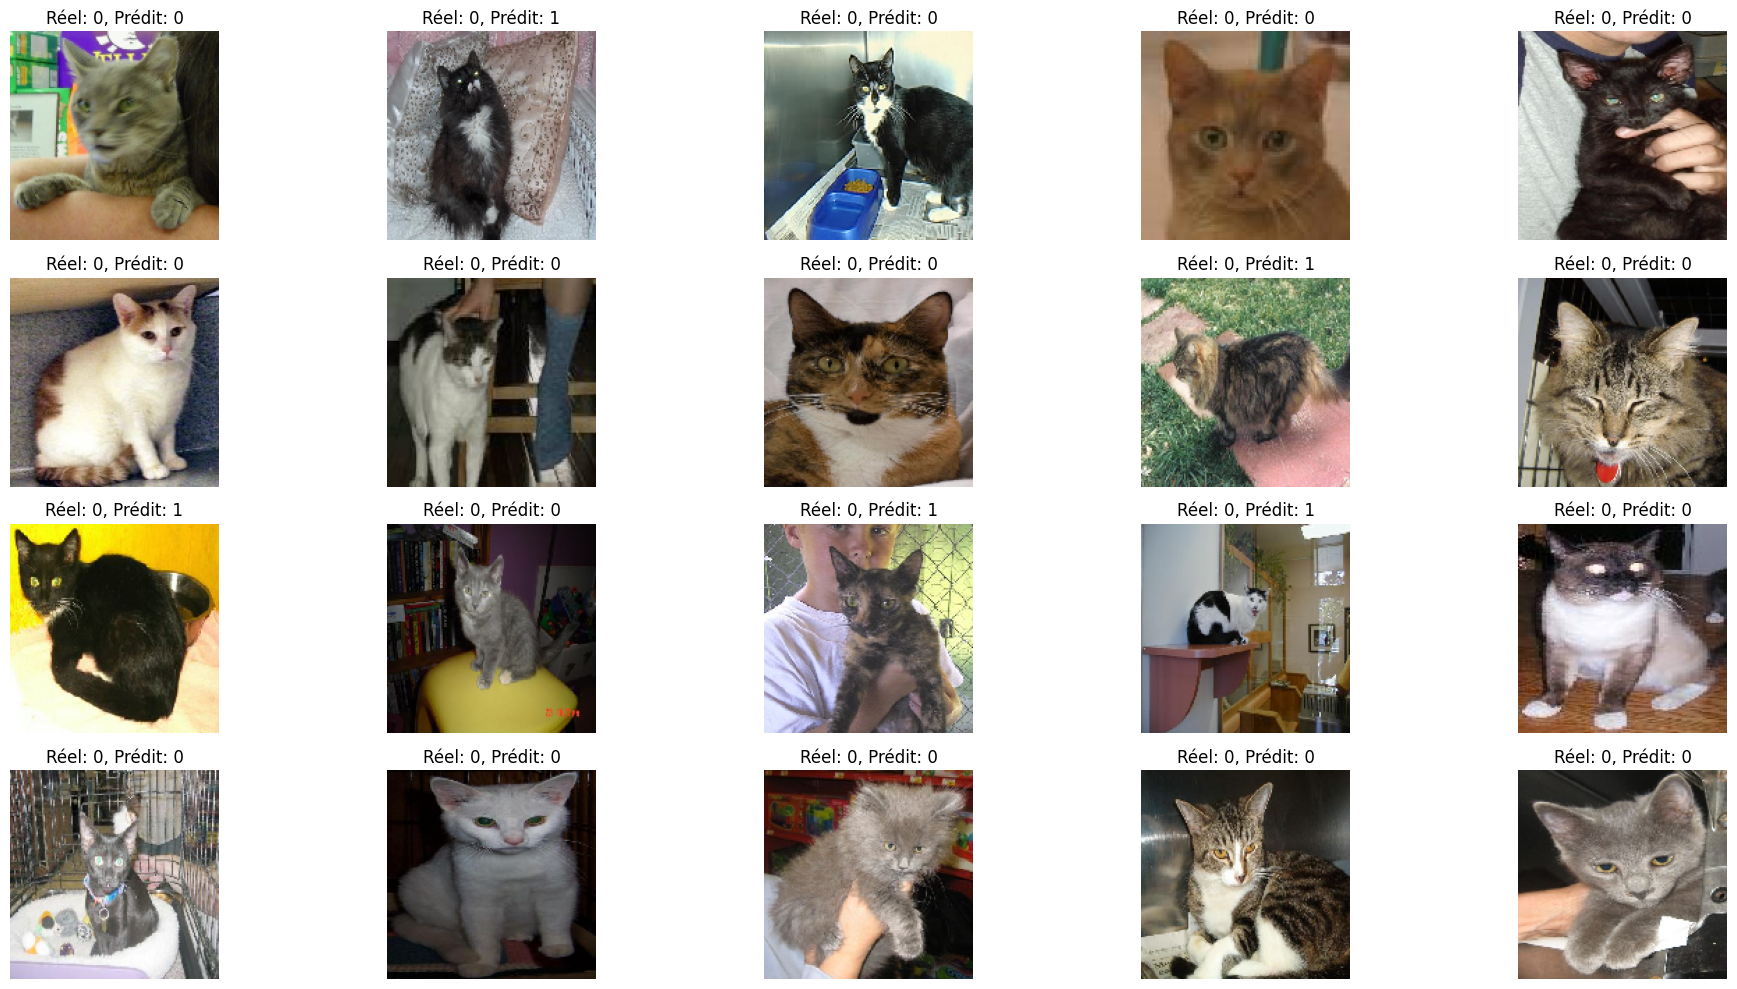

In [73]:
# Afficher les résultats pour les 20 images (10 chats et 10 chiens)
plt.figure(figsize=(20, 10))
for i, row in df_final.head(20).iterrows():
    img_path = os.path.join(pet_images_dir, row['filename'])
    img = load_img(img_path, target_size=(150, 150))
    plt.subplot(4, 5, i + 1)
    plt.imshow(img)
    plt.title(f"Réel: {row['category']}, Prédit: {row['predictions']}")
    plt.axis('off')

plt.tight_layout()
plt.show()